In [87]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import ADASYN
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import copy 
from imblearn.over_sampling import SMOTE 
from datetime import datetime
import datetime
from sklearn import metrics
from pathlib import Path
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [88]:
path = Path('DataSet')

df_train = pd.read_csv(path/'Train.csv', low_memory=False)
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
test_id_code = df_test.id_code

print(df_train.shape)
print(df_test.shape)
df_train.head()

(1284, 19)
(964, 18)


,id_code,current_date,current_time,source_name,destination_name,train_name,target,country_code_source,longitude_source,latitude_source,mean_halt_times_source,country_code_destination,longitude_destination,latitude_destination,mean_halt_times_destination,current_year,current_week,current_day,is_weekend
0,isfywypmkqqhyft,2016-07-27,08:05:51 PM,station$147,station$1,ICZVZS,high,whber,4.356801,50.845658,634.16474,NaN,NaN,NaN,NaN,2016,30,Wednesday,False
1,mqsfxyvuqpbwomk,2016-07-27,08:06:11 PM,station$147,station$1,ICZVZS,high,whber,4.356801,50.845658,634.16474,NaN,NaN,NaN,NaN,2016,30,Wednesday,False
2,alspwwtbdvqsgby,2016-07-27,08:08:57 PM,station$147,station$1,ICZVZS,high,whber,4.356801,50.845658,634.16474,NaN,NaN,NaN,NaN,2016,30,Wednesday,False
3,szitxhhqduyrqpg,2016-07-27,08:09:08 PM,station$147,station$1,ICZVZS,high,whber,4.356801,50.845658,634.16474,NaN,NaN,NaN,NaN,2016,30,Wednesday,False
4,krisdqzczivvwcp,2016-07-27,08:11:01 PM,station$147,station$1,ICZVZS,high,whber,4.356801,50.845658,634.16474,NaN,NaN,NaN,NaN,2016,30,Wednesday,False


<h3>Data preprocessing</h3>

In [89]:
Target_Volume = {"high": 2, "medium": 1, "low": 0 }
Predict_Volume = {2: "high", 1: "medium", 0: "low" }
is_weekend = {"False": 0 , "True": 1}

def ChangeTime(x):
    if x != "":
        dt = datetime.datetime.strptime(x, "%I:%M:%S %p")
        seconds = dt.second + dt.minute * 60 + dt.hour * 60 * 60
        #print(seconds)
        return int(seconds)
    else:
        return ""

def ConvertStations(x):
    if x != "":
        x = x.replace("station$", "")
        return int(x)
    else:
        return ""

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_station_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def Prepare(dataset):
    dataset["current_time"] = dataset["current_time"].apply(ChangeTime)
    dataset["source_name"] = dataset["source_name"].apply(ConvertStations)
    dataset["destination_name"] = dataset["destination_name"].apply(ConvertStations)
    dataset["is_weekend"] = dataset["is_weekend"].apply(lambda x: is_weekend[str(x)])
    dataset = dataset.sort_values(by=['current_date', 'current_time'])
    return dataset

In [90]:
df_train = Prepare(df_train)
df_test = Prepare(df_test)
df_train["target"] = df_train["target"].apply(lambda x: Target_Volume[x])    

In [91]:
def calculate_empty(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [92]:
calculate_empty(df_train).head()

,Total,Percent
mean_halt_times_destination,33,0.025701
latitude_destination,33,0.025701
longitude_destination,33,0.025701
country_code_destination,33,0.025701
latitude_source,1,0.000779


<h3>A. Haversine Distance Between the Two Lat/Lons:</h3>

In [93]:
def fill_all_empty(dataset):
    dataset["longitude_destination"] = dataset["longitude_destination"].fillna(0)
    dataset["latitude_destination"] = dataset["latitude_destination"].fillna(0)
    dataset["longitude_source"] = dataset["longitude_source"].fillna(0)
    dataset["latitude_source"] = dataset["latitude_source"].fillna(0)
    dataset["mean_halt_times_destination"] = dataset["mean_halt_times_destination"].fillna(0)
    dataset["mean_halt_times_source"] = dataset["mean_halt_times_source"].fillna(0)
    
    dataset["country_code_source"] = dataset["country_code_source"].fillna("None")
    dataset["country_code_destination"] = dataset["country_code_destination"].fillna("None")
    
    dataset["station_diff"] = np.abs(dataset["source_name"] - dataset["destination_name"])
    dataset.loc[:, 'center_latitude'] = (dataset['latitude_source'].values + dataset['latitude_destination'].values) / 2
    dataset.loc[:, 'center_longitude'] = (dataset['longitude_source'].values + dataset['longitude_destination'].values) / 2
    
    # B. Manhattan Distance Between the two Lat/Lons:
    dataset.loc[:, 'dummy_station_distance'] = dummy_station_distance(dataset['latitude_source'].values, dataset['longitude_source'].values, 
                                                     dataset['latitude_destination'].values,  dataset['longitude_destination'].values)
    
    return dataset


df_train = fill_all_empty(df_train)
df_test = fill_all_empty(df_test)

In [94]:
print("Train X", df_train.shape)
print("Test X", df_test.shape)

Train X (1284, 23)
Test X (964, 22)


In [95]:
def create_time_difference(dataset):
    dataset["delay_time"] = 0
    _dates = dataset["current_date"].unique()
    final_data = pd.DataFrame()
    #print(_dates)
    for date in _dates:
        dataset_block = dataset.loc[dataset["current_date"] == date]
        delay_time = dataset_block["current_time"].diff().values
        dataset.loc[dataset["current_date"] == date, "delay_time"] = delay_time
        """
        dataset_count_df = pd.DataFrame({'current_date' : dataset_block["current_date"].values, 
                                       'delay_time': delay_time})
        final_data = pd.concat([final_data, dataset_count_df], ignore_index=True)
        print("final_data X", final_data.shape)
        del dataset_count_df
        """
    dataset["delay_time"] = dataset["delay_time"].fillna(0)
    del final_data
    return dataset

df_train = create_time_difference(df_train)
df_test = create_time_difference(df_test)

In [96]:
print("Train X", df_train.shape)
print("Test X", df_test.shape)
df_train.head()

Train X (1284, 24)
Test X (964, 23)


,id_code,current_date,current_time,source_name,destination_name,train_name,target,country_code_source,longitude_source,latitude_source,...,mean_halt_times_destination,current_year,current_week,current_day,is_weekend,station_diff,center_latitude,center_longitude,dummy_station_distance,delay_time
0,isfywypmkqqhyft,2016-07-27,72351,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,0.0
1,mqsfxyvuqpbwomk,2016-07-27,72371,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,20.0
2,alspwwtbdvqsgby,2016-07-27,72537,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,166.0
3,szitxhhqduyrqpg,2016-07-27,72548,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,11.0
4,krisdqzczivvwcp,2016-07-27,72661,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,113.0


In [97]:
df_train.head()

,id_code,current_date,current_time,source_name,destination_name,train_name,target,country_code_source,longitude_source,latitude_source,...,mean_halt_times_destination,current_year,current_week,current_day,is_weekend,station_diff,center_latitude,center_longitude,dummy_station_distance,delay_time
0,isfywypmkqqhyft,2016-07-27,72351,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,0.0
1,mqsfxyvuqpbwomk,2016-07-27,72371,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,20.0
2,alspwwtbdvqsgby,2016-07-27,72537,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,166.0
3,szitxhhqduyrqpg,2016-07-27,72548,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,11.0
4,krisdqzczivvwcp,2016-07-27,72661,147,1,ICZVZS,2,whber,4.356801,50.845658,...,0.0,2016,30,Wednesday,0,146,25.422829,2.1784,5959.624851,113.0


<h3>Normalization</h3>

In [98]:
def normalize_data(dataset):
    dataset["current_time"] = StandardScaler().fit_transform(np.array(dataset['current_time']).reshape(-1, 1))
    dataset["source_name"] = StandardScaler().fit_transform(np.array(dataset['source_name']).reshape(-1, 1))
    dataset["destination_name"] = StandardScaler().fit_transform(np.array(dataset['destination_name']).reshape(-1, 1))
    dataset["mean_halt_times_destination"] = StandardScaler().fit_transform(np.array(dataset['mean_halt_times_destination']).reshape(-1, 1))
    dataset["mean_halt_times_source"] = StandardScaler().fit_transform(np.array(dataset['mean_halt_times_source']).reshape(-1, 1))
    dataset["station_diff"] = StandardScaler().fit_transform(np.array(dataset['station_diff']).reshape(-1, 1))
    dataset["dummy_station_distance"] = StandardScaler().fit_transform(np.array(dataset['dummy_station_distance']).reshape(-1, 1))
    dataset["delay_time"] = StandardScaler().fit_transform(np.array(dataset['delay_time']).reshape(-1, 1))
    dataset["center_latitude"] = StandardScaler().fit_transform(np.array(dataset['delay_time']).reshape(-1, 1))
    
    dataset["halt_times_diff"] = np.abs(dataset["mean_halt_times_source"] - dataset["mean_halt_times_destination"])
    return dataset

df_train = normalize_data(df_train)
df_test = normalize_data(df_test)

In [99]:
#df_train.groupby(["current_date"])["train_name"].nunique()
def other_feature_engineering(dataset):
    train_count_df = pd.DataFrame({'total_train_count' : dataset.groupby( [ "current_date"] )["train_name"].count()}).reset_index()
    train_count_df["total_train_count"] = StandardScaler().fit_transform(np.array(train_count_df['total_train_count']).reshape(-1, 1))
    dataset = pd.merge(dataset, train_count_df, on='current_date', how='left')
    del train_count_df
    return dataset

df_train = other_feature_engineering(df_train)
df_test = other_feature_engineering(df_test)

In [100]:
#df_train.to_csv("tempsave.csv")

In [101]:
#df_train["current_time"]

In [102]:
df_train.describe()

,current_time,source_name,destination_name,target,longitude_source,latitude_source,mean_halt_times_source,longitude_destination,latitude_destination,mean_halt_times_destination,current_year,current_week,is_weekend,station_diff,center_latitude,center_longitude,dummy_station_distance,delay_time,halt_times_diff,total_train_count
count,1.284000e+03,1.284000e+03,1.284000e+03,1284.000000,1284.000000,1284.000000,1.284000e+03,1284.000000,1284.000000,1.284000e+03,1284.0,1284.000000,1284.000000,1.284000e+03,1.284000e+03,1284.000000,1.284000e+03,1.284000e+03,1284.000000,1284.000000
mean,1.390373e-16,5.421416e-17,-1.036727e-16,0.890966,4.289138,50.895006,5.559762e-17,4.188345,49.615761,3.886645e-16,2016.0,36.781153,0.146417,-7.142089e-17,1.265862e-16,4.238741,5.317657e-18,1.335035e-16,1.064768,1.098788
std,1.000390e+00,1.000390e+00,1.000390e+00,0.841599,0.565119,1.436314,1.000390e+00,0.876005,8.066826,1.000390e+00,0.0,3.175253,0.353662,1.000390e+00,1.000390e+00,0.610943,1.000390e+00,1.000390e+00,0.878328,1.118219
min,-2.700968e+00,-1.674902e+00,-1.607969e+00,0.000000,-0.126061,0.000000,-1.213789e+00,0.000000,0.000000,-1.125917e+00,2016.0,30.000000,0.000000,-7.301949e-01,-3.976179e-01,0.097505,-2.000011e-01,-3.976179e-01,0.001894,-0.866857
25%,-9.918693e-01,-8.472319e-01,-7.963126e-01,0.000000,4.039653,50.845658,-8.709059e-01,3.922155,50.835707,-8.530692e-01,2016.0,36.000000,0.000000,-6.747121e-01,-3.953732e-01,4.023603,-1.892122e-01,-3.953732e-01,0.241978,0.214056
50%,2.288845e-01,-4.940925e-01,-4.500058e-01,1.000000,4.360846,50.896456,-4.248307e-01,4.356801,50.882280,-4.270402e-01,2016.0,38.000000,0.000000,-5.429403e-01,-3.393595e-01,4.356028,-1.749649e-01,-3.393595e-01,0.872826,0.949077
75%,7.274210e-01,1.221944e+00,1.232829e+00,2.000000,4.482785,51.056365,8.306319e-01,4.482785,51.035896,6.663182e-01,2016.0,39.000000,0.000000,2.130138e-01,-1.123289e-01,4.536333,-1.449160e-01,-1.123289e-01,1.656434,1.900280
max,1.939927e+00,1.884080e+00,1.882154e+00,2.000000,5.982265,51.925093,1.785748e+00,6.958823,52.379128,1.792600e+00,2016.0,40.000000,1.000000,3.743111e+00,1.223570e+01,5.915149,6.152910e+00,1.223570e+01,2.954080,3.283849


Skewness: -0.172598
Kurtosis: -0.915730


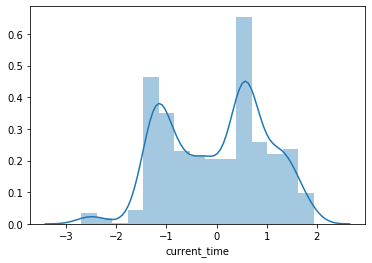

In [103]:
sns.distplot(df_train['current_time']);
print("Skewness: %f" % df_train['current_time'].skew())
print("Kurtosis: %f" % df_train['current_time'].kurt())

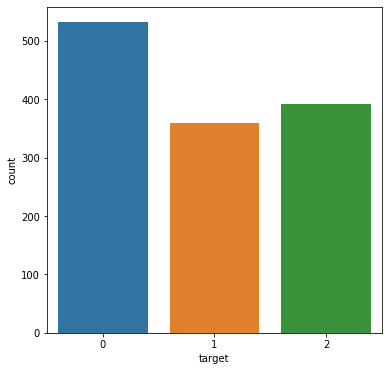

In [104]:
plt.figure(figsize=(6, 6))
sns.countplot(x="target", data=df_train)

In [105]:
def remove_unwanted_features(dataset):
    dataset = dataset.drop(["id_code", "current_date"], axis=1)
    dataset = dataset.drop(["current_year", "current_week"], axis=1)
    #dataset = dataset.drop(["longitude_source", "latitude_source", "longitude_destination", "latitude_destination"], axis=1)
    return dataset

df_train = remove_unwanted_features(df_train)
df_test = remove_unwanted_features(df_test)

<h3>Heat map</h3>

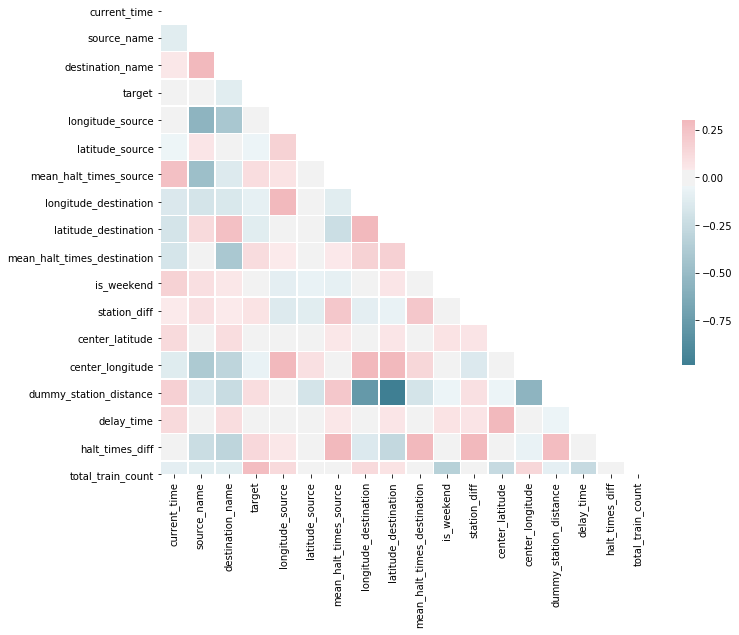

In [106]:
corr = df_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [107]:
#hello
print("Train X", df_train.shape)
print("Test X", df_test.shape)

Train X (1284, 22)
Test X (964, 21)


In [108]:
mergedata = pd.concat([df_train, df_test], sort=False)
mergedata_pandas = pd.get_dummies(mergedata)

df_train = mergedata_pandas[:df_train.shape[0]]
df_test = mergedata_pandas[df_train.shape[0]:]

RANDOM_SEED = 1

y = df_train.target # Target variable
X = df_train.drop(["target"], axis=1)
df_test = df_test.drop(["target"], axis=1)

In [109]:
#sns.pairplot(df_train)
print("Train X", X.shape)
print("Test X", df_test.shape)

Train X (1284, 901)
Test X (964, 901)


In [110]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=RANDOM_SEED, test_size=0.2)

<h3>Over Sampling</h3>

In [111]:
#sm = SMOTE(random_state = 42) 
#X, y = sm.fit_resample(X, y) 

#X_train, y_train = ADASYN().fit_resample(X, y)

In [112]:
def score(params):
    try:

        print("Training with params: ",params)
        num_round = int(params['n_estimators'])
        del params['n_estimators']
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)
        watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
        gbm_model = xgb.train(params, dtrain, num_round,
                              evals=watchlist,
                              verbose_eval=False)
        predictions = gbm_model.predict(dvalid,
                                        ntree_limit=gbm_model.best_iteration + 1)
        predictions = (predictions >= 0.5).astype('int')
        score = f1_score(y_valid, predictions, average='weighted')
        print("\tScore {0}\n\n".format(score))
        
        # The score function should return the loss (1-score)
        # since the optimize function looks for the minimum
        loss = 1 - score
        return {'loss': loss, 'status': STATUS_OK}
   
    # In case of any exception or assertionerror making score 0, so that It can return maximum loss (ie 1)
    except AssertionError as obj:
        #print("AssertionError: ",obj)
        loss = 1 - 0
        return {'loss': loss, 'status': STATUS_OK}

    except Exception as obj:
        #print("Exception: ",obj)
        loss = 1 - 0
        return {'loss': loss, 'status': STATUS_OK}

In [113]:
def optimize(
             trials, 
             max_evals, 
             random_state=RANDOM_SEED):


    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # To learn more about XGBoost parameters, head to this page: 
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 300, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 7, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'scale_pos_weight': hp.quniform('scale_pos_weight', 1,4, 0.05),
        "reg_alpha": hp.quniform('reg_alpha', 0, 1, 0.05),
        "reg_lambda": hp.quniform('reg_lambda', 1, 5, 0.05),
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        'nthread': 4,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': random_state
    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, 
                space, 
                algo=tpe.suggest, 
                trials=trials, 
                max_evals=max_evals)
    return best

In [114]:
trials = Trials()
MAX_EVALS = 25

best_hyperparams = optimize(trials, MAX_EVALS)
print("The best hyperparameters are: ", "\n")
print(best_hyperparams)

Training with params:                               
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.15000000000000002, 'eval_metric': 'logloss', 'gamma': 0.4, 'max_depth': 4, 'min_child_weight': 4.0, 'n_estimators': 203.0, 'nthread': 4, 'objective': 'binary:logistic', 'reg_alpha': 0.9500000000000001, 'reg_lambda': 2.0, 'scale_pos_weight': 2.6500000000000004, 'seed': 1, 'silent': 1, 'subsample': 0.6000000000000001, 'tree_method': 'exact'}
Training with params:                               
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.07500000000000001, 'eval_metric': 'logloss', 'gamma': 0.7000000000000001, 'max_depth': 6, 'min_child_weight': 4.0, 'n_estimators': 132.0, 'nthread': 4, 'objective': 'binary:logistic', 'reg_alpha': 0.4, 'reg_lambda': 3.35, 'scale_pos_weight': 1.05, 'seed': 1, 'silent': 1, 'subsample': 0.9, 'tree_method': 'exact'}
Training with params:                                         
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.1, 'e

/home/koushik/.conda/envs/image-segmentation/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Training with params:                                         
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.47500000000000003, 'eval_metric': 'logloss', 'gamma': 0.9500000000000001, 'max_depth': 4, 'min_child_weight': 6.0, 'n_estimators': 297.0, 'nthread': 4, 'objective': 'binary:logistic', 'reg_alpha': 0.9500000000000001, 'reg_lambda': 1.0, 'scale_pos_weight': 1.25, 'seed': 1, 'silent': 1, 'subsample': 0.75, 'tree_method': 'exact'}
Training with params:                                         
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.35000000000000003, 'eval_metric': 'logloss', 'gamma': 0.75, 'max_depth': 3, 'min_child_weight': 3.0, 'n_estimators': 279.0, 'nthread': 4, 'objective': 'binary:logistic', 'reg_alpha': 0.30000000000000004, 'reg_lambda': 3.6500000000000004, 'scale_pos_weight': 1.55, 'seed': 1, 'silent': 1, 'subsample': 0.9, 'tree_method': 'exact'}
Training with params:                                         
{'booster'

100%|██████████| 25/25 [00:01<00:00, 17.63it/s, best loss: 1.0]
The best hyperparameters are:  

{'colsample_bytree': 0.9, 'eta': 0.15000000000000002, 'gamma': 0.4, 'max_depth': 3, 'min_child_weight': 4.0, 'n_estimators': 203.0, 'reg_alpha': 0.9500000000000001, 'reg_lambda': 2.0, 'scale_pos_weight': 2.6500000000000004, 'subsample': 0.6000000000000001}


In [115]:
best_hyperparams

{'colsample_bytree': 0.9,
 'eta': 0.15000000000000002,
 'gamma': 0.4,
 'max_depth': 3,
 'min_child_weight': 4.0,
 'n_estimators': 203.0,
 'reg_alpha': 0.9500000000000001,
 'reg_lambda': 2.0,
 'scale_pos_weight': 2.6500000000000004,
 'subsample': 0.6000000000000001}

In [116]:
param = best_hyperparams
num_round = int(param['n_estimators'])
del param['n_estimators']

In [129]:
def ConvertOutput(x):
    x_ = x
    if x > 0.9 and x < 2:
        x_ = 1
    elif x > 1.5:
        x_ = 2
    else:
        x_ = 0    
    return x_

In [118]:
num_splits = 5
skf = StratifiedKFold(n_splits= num_splits, random_state= RANDOM_SEED, shuffle=True)

In [119]:
dxtest = xgb.DMatrix(df_test)

In [120]:
y_test_pred = np.zeros((df_test.shape[0], 1))
print(y_test_pred.shape)
y_valid_scores = []

X_TRAIN = X.copy()
Y_TRAIN = y.copy()
X_TRAIN = X_TRAIN.reindex()
Y_TRAIN = Y_TRAIN.reindex()

fold_cnt = 1
for train_index, test_index in skf.split(X_TRAIN,Y_TRAIN):
    print("FOLD .... ",fold_cnt)
    fold_cnt += 1
    
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_valid = X_TRAIN.iloc[train_index], X_TRAIN.iloc[test_index]
    y_train, y_valid = Y_TRAIN.iloc[train_index], Y_TRAIN.iloc[test_index]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    
    evallist = [(dtrain, 'train'), (dvalid, 'eval')]

    # Training xgb model
    bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=50)
    
    # Predict Validation
    y_pred_valid = bst.predict(dvalid, ntree_limit=bst.best_iteration + 1)
    y_valid_scores.append(metrics.accuracy_score(y_valid, np.floor(y_pred_valid)))
   
    # Predict Test 
    y_pred = bst.predict(dxtest, ntree_limit=bst.best_iteration+1)
    
    y_test_pred += y_pred.reshape(-1,1)

#Normalize test predicted probability
y_test_pred /= num_splits

(964, 1)
FOLD ....  1
TRAIN: [   0    2    3 ... 1281 1282 1283] TEST: [   1   10   11   12   14   15   16   28   31   35   38   40   41   67
   80   82   85   93   94   95   97  104  123  126  127  128  141  146
  153  160  175  180  183  186  196  198  208  212  213  223  224  231
  249  255  262  266  267  270  282  289  291  295  307  308  314  321
  325  326  328  334  335  360  362  368  371  373  388  389  395  398
  404  407  410  425  426  428  430  432  437  443  445  450  458  460
  466  473  475  484  490  495  504  508  511  512  515  521  524  534
  536  542  544  545  547  549  559  568  569  575  584  586  588  590
  604  608  611  618  620  634  635  639  641  643  650  653  659  660
  666  672  681  682  694  695  697  699  704  716  718  719  733  736
  743  753  756  762  764  767  770  771  773  776  777  780  784  785
  789  790  791  794  795  801  804  813  815  823  831  835  836  842
  848  851  854  855  861  872  874  877  886  889  894  913  914  916
  922 

/home/koushik/.conda/envs/image-segmentation/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:0.633172	eval-rmse:0.766547
[100]	train-rmse:0.563414	eval-rmse:0.75325
[150]	train-rmse:0.509798	eval-rmse:0.762093
[200]	train-rmse:0.469765	eval-rmse:0.766907
[202]	train-rmse:0.46857	eval-rmse:0.769051
FOLD ....  2
TRAIN: [   0    1    2 ... 1279 1282 1283] TEST: [   6   18   20   23   24   36   42   44   52   53   54   61   62   63
   68   73   77   78   90   91  102  116  117  120  122  130  131  136
  143  148  149  150  159  161  162  165  168  171  174  179  184  199
  200  202  205  207  215  219  226  227  230  233  244  250  251  252
  254  258  261  264  265  271  276  277  285  292  297  300  301  302
  309  310  315  317  332  343  344  347  364  374  375  382  390  394
  402  408  419  424  435  444  447  455  457  464  468  481  482  491
  497  502  510  519  522  523  526  528  529  533  543  550  552  554
  561  563  574  578  582  589  595  597  599  610  616  625  627  631
  633  644  646  649  651  654  657  662  663  667  670  671  673  675
  684 

In [121]:
y_valid_scores

[0.43023255813953487, 0.4108527131782946, 0.40625, 0.453125, 0.42578125]

In [122]:
print("Average validation_score: ",np.mean(y_valid_scores))

Average validation_score:  0.42524830426356586


In [123]:
y_test_pred

array([[ 1.00417137],
       [ 1.0998741 ],
       [ 0.66520204],
       [ 1.03058283],
       [ 1.27854021],
       [ 1.20840909],
       [ 1.04525032],
       [ 1.341699  ],
       [ 1.10341494],
       [ 1.2246876 ],
       [ 1.05727826],
       [ 1.02407568],
       [ 1.18369312],
       [ 1.06407642],
       [ 0.659065  ],
       [ 1.21990569],
       [ 1.09311374],
       [ 1.00518006],
       [ 0.4320778 ],
       [ 0.51118194],
       [ 0.60444353],
       [ 0.58328639],
       [ 0.65845261],
       [ 0.37259873],
       [ 0.28134965],
       [ 0.06070769],
       [ 0.56202128],
       [ 1.18611035],
       [ 1.31715817],
       [ 0.72988535],
       [ 1.0185872 ],
       [ 0.91266832],
       [ 1.35404799],
       [ 1.35404799],
       [ 1.14064479],
       [ 0.78547823],
       [ 0.81038151],
       [ 1.03776444],
       [ 0.74111964],
       [ 0.72511888],
       [ 0.65093812],
       [ 0.86485772],
       [ 0.79655976],
       [ 0.79655976],
       [ 0.67582059],
       [ 1

In [130]:
submission = pd.DataFrame({'id_code' : test_id_code.values})
submission['target'] = y_test_pred
submission['target'] = submission['target'].apply(ConvertOutput)    
submission['target'] = submission['target'].astype('int64', copy=False)
submission['target'] = submission['target'].apply(lambda x: Predict_Volume[x])    
submission.head()

,id_code,target
0,mckbezdplrukagl,medium
1,agxwrnbmzbyxsjg,medium
2,iqjojyewdyfshtj,low
3,hssqexnzirioaag,medium
4,lublknpfraiznhr,medium


In [131]:
submission.to_csv("submission_v7.csv", index=False)